In [1]:
import os
import json
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

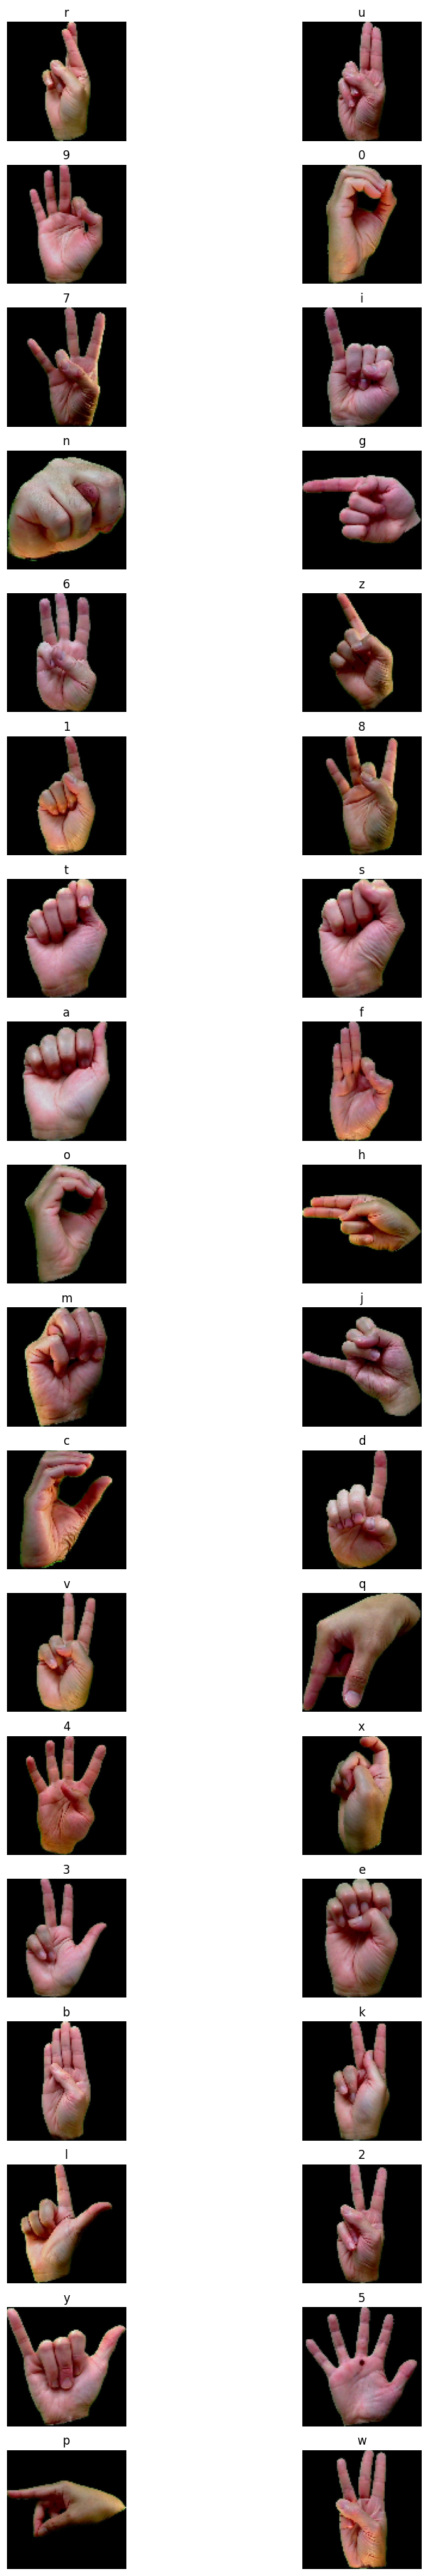

Total de imágenes: 2515
Número de imágenes por categoría:
r: 70
u: 70
9: 70
0: 70
7: 70
i: 70
n: 70
g: 70
6: 70
z: 70
1: 70
8: 70
t: 65
s: 70
a: 70
f: 70
o: 70
h: 70
m: 70
j: 70
c: 70
d: 70
v: 70
q: 70
4: 70
x: 70
3: 70
e: 70
b: 70
k: 70
l: 70
2: 70
y: 70
5: 70
p: 70
w: 70


In [2]:
# Directorio de datos y obtención de las categorías
data_dir = 'asl_dataset'
asl_categories = os.listdir(data_dir)

# Visualización de una imagen de cada categoría
plt.figure(figsize=(10, 50))
for i, category in enumerate(asl_categories):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[0]
    img_path = os.path.join(folder, image_file)
    img = keras.preprocessing.image.load_img(img_path, target_size=(100, 100))
    plt.subplot(int(len(asl_categories)/2) + 1, 2, i+1)
    plt.title(category)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Análisis del tamaño y distribución de clases
image_count = {}
total_images = 0
for category in asl_categories:
    folder = os.path.join(data_dir, category)
    count = len(os.listdir(folder))
    image_count[category] = count
    total_images += count

print(f"Total de imágenes: {total_images}")
print("Número de imágenes por categoría:")
for category, count in image_count.items():
    print(f"{category}: {count}")

In [3]:
# Recopilación de rutas y etiquetas
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir)
             for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths]

# Crear DataFrame
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Dividir en entrenamiento (70%), validación (20%) y test (10%)
train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=13)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=13)

print("Total de imágenes:", len(data_df))
print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Test:", len(test_df))

Total de imágenes: 2515
Entrenamiento: 1760
Validación: 504
Test: 251


In [4]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#Convertir los datos a dataframes
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(100, 100),
    batch_size=32
)

val_generator = test_val_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(100, 100),
    batch_size=32
)

test_generator = test_val_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(100, 100),
    batch_size=32
)

Found 1760 validated image filenames belonging to 36 classes.
Found 1760 validated image filenames belonging to 36 classes.
Found 1760 validated image filenames belonging to 36 classes.


In [5]:
model = Sequential([
    #Primera capa de convolución y pooling
    Conv2D(18, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    Conv2D(18, (1, 1), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),

    #Segunda capa de convolución y pooling
    Conv2D(32, (3,3), activation='relu'),
    Conv2D(32, (1, 1), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),

    #Aplanamiento y capas densas
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(asl_categories), activation='softmax')
])

model.summary()


/Users/juandanielcastrellon/Documents/Universidad/Maestria/Semestre 3/Deep Learning/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 18)     │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 18)     │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 47, 47, 32)     │         5,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 47, 47, 32)     │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       541,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         1,188 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 550,034 (2.10 MB)

 Trainable params: 550,034 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True,
                                   monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

callbacks = [model_checkpoint, early_stopping, reduce_lr]

In [8]:

%%time
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks)

Epoch 1/50


/Users/juandanielcastrellon/Documents/Universidad/Maestria/Semestre 3/Deep Learning/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0591 - loss: 3.4748 - val_accuracy: 0.1273 - val_loss: 3.0971 - learning_rate: 0.0010
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.1835 - loss: 2.9421 - val_accuracy: 0.3608 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.3114 - loss: 2.4185 - val_accuracy: 0.5386 - val_loss: 1.6727 - learning_rate: 0.0010
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.3960 - loss: 1.9926 - val_accuracy: 0.6210 - val_loss: 1.2945 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.4608 - loss: 1.7779 - val_accuracy: 0.6869 - val_loss: 1.1318 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.5063 - loss: 1.5789 - val_accuracy: 0.7551 - val_loss: 0.8298 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5472 - loss: 1.3986 - val_accurac

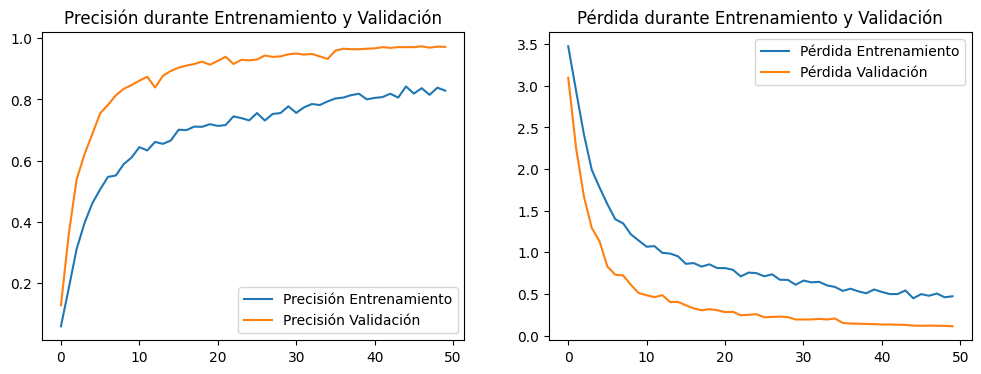

In [11]:
# Visualización de la evolución del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión Validación')
plt.legend(loc='lower right')
plt.title('Precisión durante Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida Validación')
plt.legend(loc='upper right')
plt.title('Pérdida durante Entrenamiento y Validación')
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


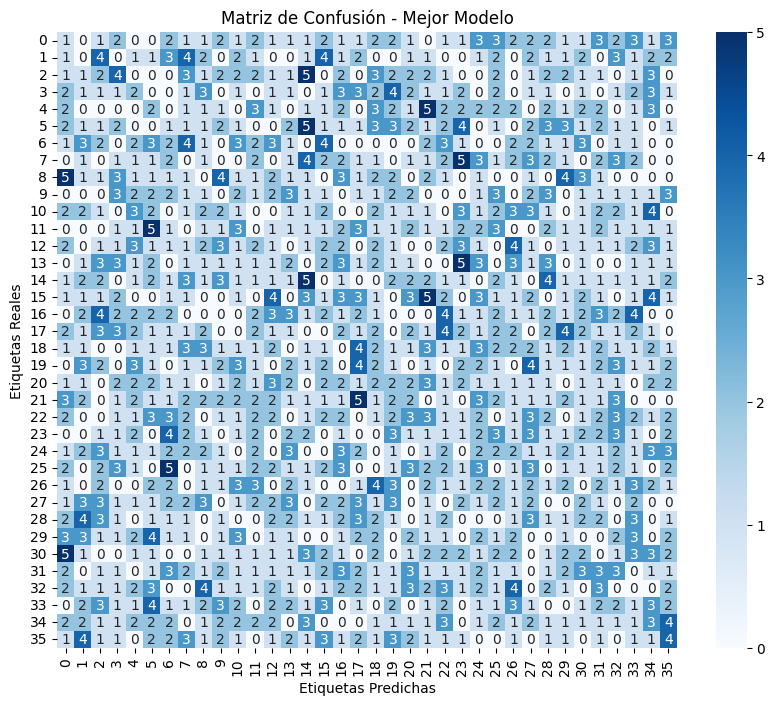

              precision    recall  f1-score   support

           r       0.02      0.02      0.02        53
           u       0.00      0.00      0.00        46
           9       0.04      0.04      0.04        50
           0       0.02      0.02      0.02        45
           7       0.00      0.00      0.00        47
           i       0.00      0.00      0.00        52
           n       0.04      0.04      0.04        48
           g       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        45
           z       0.00      0.00      0.00        44
           1       0.02      0.02      0.02        48
           8       0.00      0.00      0.00        45
           t       0.02      0.02      0.02        48
           s       0.04      0.04      0.04        47
           a       0.10      0.10      0.10        49
           f       0.02      0.02      0.02        50
           o       0.02      0.02      0.02        53
           h       0.02    

In [12]:
# Cargar el modelo guardado con el mejor desempeño en validación
best_model = load_model('best_model.keras')

# Evaluar el modelo en el conjunto de test
test_generator.reset()
predicciones = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(predicciones, axis=1)
y_test = test_generator.classes

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Etiquetas Reales')
plt.xlabel('Etiquetas Predichas')
plt.show()

print(classification_report(y_test, y_pred, target_names=asl_categories, zero_division=0))